<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing Data Stage 2: SN and masked fraction cuts


In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import copy
import pandas as pd

In [2]:
import numpy
numpy.__version__


'1.18.1'

In [6]:
root_prepped

'/global/cscratch1/sd/vboehm/Datasets/sdss/prepped'

In [3]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

/usr/bin/sh: pip: command not found


In [4]:
a = np.arange(4)
ind = np.where([0,1,0,1])
a[ind]

array([1, 3])

In [3]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'
root_intermed   = '/global/cscratch1/sd/vboehm/Datasets/SDSS_preprocessing_steps/'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)

In [6]:
label_

'galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50'

In [7]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [8]:
subselect = pd.read_csv('../PAE_targets.csv')
MJD_t   = subselect['mjd']
plate_t = subselect['plate']
fiber_t = subselect['fiberid']
obj = [[MJD_t[ii], plate_t[ii], fiber_t[ii]] for ii in range(len(subselect))]

In [10]:
masked_counts=0
for nn in range(6):
    print(nn)
    arrays = [np.asarray([[],[]]) for jj in range(12)]
    array_ = np.load(os.path.join(root_data,'SDSS_BOSS_preprocessed/%s_%d_target_selection_QSO_GAL.npy'%(label,nn)), allow_pickle=True)
    masked_ = np.load(os.path.join(root_data,'SDSS_BOSS_preprocessed/%s_%d_target_selection_QSO_GAL_maskedout.npy'%(label,nn)))
    masked_counts+=len(masked_)
    for jj in range(12):
        arr = np.vstack(array_[jj])
        arrays[jj] = np.append(arrays[jj],arr)
    res_fluxes_,res_inv_vars_,res_masks_,redshifts_,SNs_, ras_, decs_, category_,sublabel_, MJD_, plate_id_, fiber_ = arrays
    if nn==0:
        res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = res_fluxes_, res_masks_, res_inv_vars_, redshifts_, SNs_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_
    else:
            res_fluxes   = np.concatenate([res_fluxes, res_fluxes_],axis=0)
            res_masks    = np.concatenate([res_masks, res_masks_],axis=0)
            res_inv_vars = np.concatenate([res_inv_vars, res_inv_vars_],axis=0)
            redshifts    = np.concatenate([redshifts, redshifts_],axis=0)
            SNs          = np.concatenate([SNs, SNs_],axis=0)
            ras          = np.concatenate([ras, ras_],axis=0)
            decs         = np.concatenate([decs, decs_],axis=0)
            category     = np.concatenate([category, category_],axis=0)
            sublabel     = np.concatenate([sublabel, sublabel_],axis=0)
            MJD          = np.concatenate([MJD, MJD_],axis=0)
            plate_id     = np.concatenate([plate_id, plate_id_],axis=0)
            fiber        = np.concatenate([fiber, fiber_],axis=0)   

0
1
2
3
4
5


In [11]:
res_fluxes_ = np.reshape(res_fluxes,[-1,1000])
res_inv_vars_ =  np.reshape(res_inv_vars,[-1,1000])
res_masks_ =  np.reshape(res_masks,[-1,1000])

In [12]:
len(res_fluxes_)

3816115

In [13]:
del res_fluxes
del res_inv_vars
del res_masks

In [14]:
redshifts_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_ = redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber

In [16]:
df1 = pd.DataFrame()
df1['MJD']   = MJD_
df1['plate'] = plate_id_
df1['fiber'] = fiber_
df1['redshift'] = redshifts_
df1['class'] = category_
df1['num']   = np.arange(len(MJD_))

df2 = pd.DataFrame()
df2['MJD']   = MJD_t
df2['plate'] = plate_t
df2['fiber'] = fiber_t
#df2['objid'] = objid_t

df_overlap=df1.merge(df2,how='inner',on=['plate','MJD','fiber'])

select = df_overlap['num']
print(len(select), max(select), len(res_fluxes_))

493741 3816112 3816115


In [23]:
masked_counts


6206

In [18]:
def target_select(indx, x):
    num = len(x)
    arrays_new = [x[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber = target_select(select, [res_fluxes_, res_masks_, res_inv_vars_, redshifts_, ras_, decs_, category_, sublabel_, MJD_, plate_id_, fiber_])

new datasize:  493741


In [39]:
Supernovas = pd.read_pickle('../forPub/Supernova_Sample.pkl')
df1 = pd.DataFrame()
df1['MJD']   = MJD
df1['plate'] = plate_id
df1['fiber'] = fiber
df1['redshift'] = redshifts
df1['class'] = category
df1.to_pickle(os.path.join(root_intermed,'step_1.pkl'))
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))

15


In [48]:
subselect = pd.read_csv('../PAE_targets.csv')
# df1 = pd.DataFrame()
# df1['MJD']   = MJD
# df1['plate'] = plate_id
# df1['fiber'] = fiber
# df1['redshift'] = redshifts
# df1.to_pickle(os.path.join(root_intermed,'step_1.pkl'))
# sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
# print(len(sns))

In [49]:
subselect.rename(columns={'fiberid':'fiber','mjd':'MJD'},inplace=True)

In [50]:
subselect=subselect[subselect['zwarning']==0]

In [51]:
len(subselect)

496973

In [54]:
sns = df1.merge(subselect,how='inner',on=['plate','MJD','fiber'])
len(sns), len(df1), len(subselect), len(pd.merge(subselect,df1,'outer',on=['plate','MJD','fiber']))

(493741, 493741, 496973, 496973)

In [55]:
496973-493741

3232

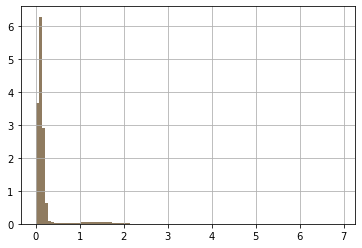

In [56]:
subselect['z'].hist(bins=100, density=True)
sns['z'].hist(bins=100, alpha=0.5, density=True)

In [81]:
sum(subselect['class']=='QSO')/len(subselect)

0.0758994955460357

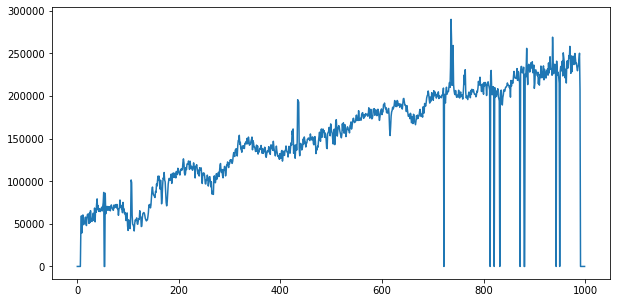

In [58]:
plt.figure(figsize=(10,5))
plt.plot(res_fluxes[np.where((MJD==51884)*(plate_id==438)*(fiber==462))[0]][0])

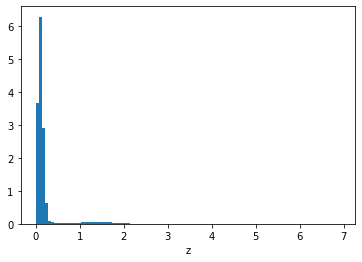

In [59]:
_ = plt.hist(redshifts,bins=100,density=True)
plt.xlabel('z')
plt.show()

In [61]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    indx = np.where((redshifts>min_z)*(redshifts<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber = redshift_bin(min_z, max_z, redshifts, [res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber])

new datasize:  389605


In [62]:
DATASET_SIZE = len(res_fluxes)

In [63]:
df1 = pd.DataFrame()
df1['MJD']   = MJD
df1['plate'] = plate_id
df1['fiber'] = fiber
df1['redshift'] = redshifts
df1.to_pickle(os.path.join(root_intermed,'step_2_redshifts.pkl'))
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))

15


In [64]:
# print(redshifts[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# print(df_overlap['objid'][np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]]==300617776005933056)
# print(category[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# print(ras[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# print(decs[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])

In [65]:
# plt.figure(figsize=(10,5))
# plt.plot(res_fluxes[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])

# plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(res_masks[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])


# plt.show()

In [66]:
boolean_mask = (res_masks==0)

In [67]:
mask_fracs = np.mean(boolean_mask,axis=1)

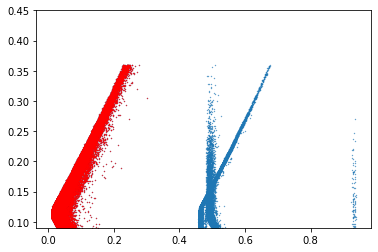

In [68]:
plt.scatter(mask_fracs, redshifts, s=0.1)
# plt.plot(mask_fracs,mask_fracs*1.15+0.19, color='orange')
# keep = redshifts>mask_fracs*1.15+0.19
# keep_low = mask_fracs<0.04
# keep = np.logical_or(keep,keep_low)
keep = mask_fracs<0.4
plt.scatter(mask_fracs[keep], redshifts[keep], color='red', s=0.1)
plt.ylim(0.09,0.45)
plt.show()

In [69]:
len(keep)

389605

In [71]:
def mask_bin(keep, arrays):
    num  = len(arrays)
    arrays_new = [arrays[ii][keep] for ii in range(num)]
    print('new datasize: ', len(arrays_new[0]))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel,MJD, plate_id, fiber = mask_bin(keep, [res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel, MJD, plate_id, fiber])

new datasize:  349122


In [72]:
DATASET_SIZE=len(res_fluxes)

In [73]:
df1 = pd.DataFrame()
df1['MJD']   = MJD
df1['plate'] = plate_id
df1['fiber'] = fiber
df1['redshift'] = redshifts
df1.to_pickle(os.path.join(root_intermed,'step_3_maskedfraction.pkl'))
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))

13


In [74]:
SNs =[]
for ii in range(DATASET_SIZE):
    SNs.append(np.sum(res_fluxes[ii][np.where(res_masks[ii])])/np.sqrt(np.sum(1./res_inv_vars[ii][np.where(res_masks[ii])])))
SNs= np.asarray(SNs)

In [75]:
for ii in np.where(np.isnan(SNs))[0]:
    print(np.sum(1./res_inv_vars[ii][np.where(res_masks[ii])]))
    print(len(np.where(res_masks[ii])[0]))

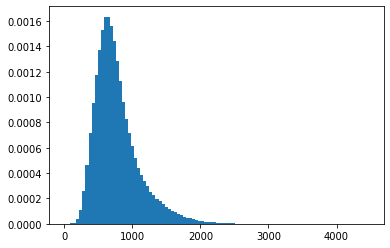

In [76]:
_ = plt.hist(SNs, density=True,bins=100)

In [77]:
new_noise = np.zeros_like(res_inv_vars)
maximum=0
for ii in range(len(new_noise)):
    pix_SNR       = res_fluxes[ii][np.where(res_masks[ii])]/np.sqrt(1./res_inv_vars[ii][np.where(res_masks[ii])])
    new_noise_    = res_inv_vars[ii][np.where(res_masks[ii])][:]
    if np.any(pix_SNR>50.):
        array =(50./res_fluxes[ii][np.where(res_masks[ii])][np.where(pix_SNR>50.)])**2
        new_noise_[np.where(pix_SNR>50.)]=array
    new_noise[ii][np.where(res_masks[ii])] = new_noise_
    if np.any(pix_SNR>50.):
        test = res_fluxes[ii][np.where(res_masks[ii])]/np.sqrt(1./new_noise[ii][np.where(res_masks[ii])])
        if max(test[np.where(pix_SNR>50.)])>maximum:
            maximum=max(test[np.where(pix_SNR>50.)])
            print(ii,maximum)


0 50.00000000000001
16 50.000000000000014


In [78]:
SNs_corr =[]
for ii in range(DATASET_SIZE):
    SNs_corr.append(np.sum(res_fluxes[ii][np.where(res_masks[ii])])/np.sqrt(np.sum(1./new_noise[ii][np.where(res_masks[ii])])))
SNs_corr= np.asarray(SNs_corr)

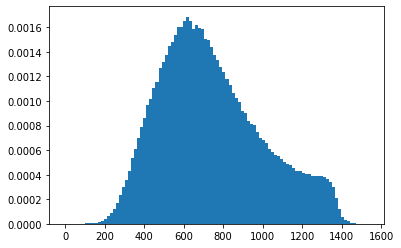

In [79]:
_ = plt.hist(SNs_corr, density=True,bins=100)

Text(0.5, 0, 'S/N')

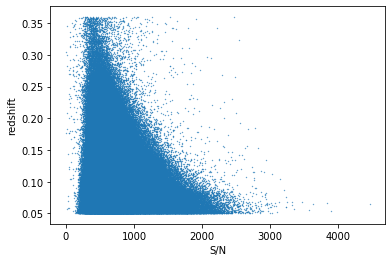

In [83]:
plt.scatter(SNs,redshifts, s=0.1)
plt.ylabel('redshift')
plt.xlabel('S/N')

Text(0.5, 0, 'S/N')

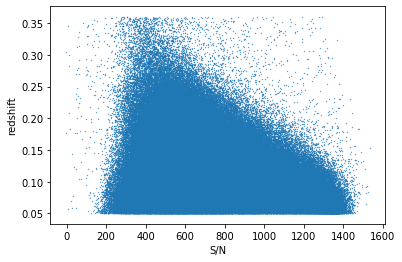

In [84]:
plt.scatter(SNs_corr,redshifts, s=0.1)
plt.ylabel('redshift')
plt.xlabel('S/N')

In [39]:
# print(redshifts[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# print(objid[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]]==300617776005933056)
# print(category[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# print(ras[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# print(decs[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])

In [40]:
# plt.figure(figsize=(10,5))
# plt.plot(res_fluxes[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])

# plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(res_masks[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])


# plt.show()

In [85]:
SNs.shape, redshifts.shape, MJD.shape

((349122,), (349122,), (349122,))

In [86]:
def SN_bin(min_SN,  SNs, arrays):
    num  = len(arrays)
    indx = np.where((SNs>min_SN))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, new_noise, redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber = SN_bin(min_SN, SNs_corr, [res_fluxes, res_masks, new_noise, redshifts,SNs_corr,ras, decs, category, sublabel, MJD, plate_id, fiber])

new datasize:  349104


In [87]:
df1 = pd.DataFrame()
df1['MJD']   = MJD
df1['plate'] = plate_id
df1['fiber'] = fiber
df1['redshift'] = redshifts
df1.to_pickle(os.path.join(root_intermed,'step_4_SNcut.pkl'))
sns= df1.merge(Supernovas,how='inner',on=['plate','MJD','fiber'])
print(len(sns))

13


In [88]:
boolean_mask = (res_masks==0)

In [89]:
mask_fracs = np.mean(boolean_mask,axis=1)
max(mask_fracs)

0.301

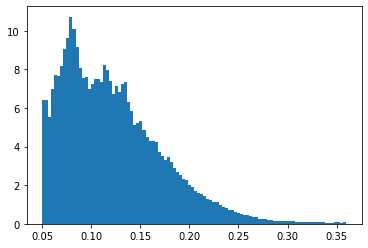

In [90]:
_ = plt.hist(redshifts, density=True, bins=100)

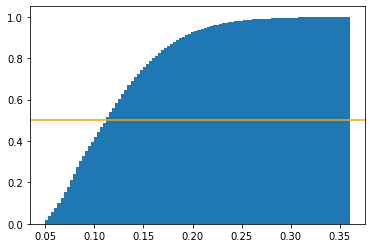

In [91]:
_ = plt.hist(redshifts, density=True, bins=100, cumulative=True)
plt.axhline(0.5,color='orange')

In [92]:
# print(redshifts[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# #print(objid[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]]==300617776005933056)
# print(category[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# print(ras[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])
# print(decs[np.where((MJD==51608)*(plate_id==267)*(fiber==9))])

[]
[]
[]
[]


In [94]:
# plt.figure(figsize=(10,5))
# plt.plot(res_fluxes[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])

# plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(res_masks[np.where((MJD==51608)*(plate_id==267)*(fiber==9))[0]][0])


# plt.show()

In [95]:
print(MJD[0],plate_id[0], fiber[0],ras[0], decs[0], redshifts[0], category[0], sublabel[0])
#fiber always one too low

53473.0 2108.0 50.0 181.9969024658203 37.638492584228516 0.10390836745500565 2.0 b''


In [97]:
np.save(os.path.join(root_prepped,'prepped_data_spectra_%s_QSO_GAL.npy'%(label_)), [res_fluxes, res_masks, new_noise])
np.save(os.path.join(root_prepped,'prepped_data_prop_%s_QSO_GAL.npy'%(label_)), [redshifts, SNs, ras, decs, category, sublabel, MJD, plate_id, fiber])

In [98]:
len(res_fluxes)

349104

In [99]:
print(root_prepped)

/global/cscratch1/sd/vboehm/Datasets/sdss/prepped
